In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer
import seaborn as sns

For this submission and onward, I took inspiration from https://www.kaggle.com/omarelgabry/a-journey-through-titanic

In [2]:
sns.set(style="ticks", color_codes=True)

In [3]:
training_file = './input/train.csv'
training_data = pd.read_csv(training_file)

In [4]:
training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
y = training_data.Survived

In [6]:
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [7]:
training_data.groupby('Embarked').Survived.aggregate(['count', 'sum'])

,count,sum
Embarked,,
C,168,93
Q,77,30
S,644,217


We have different survival percentage depending on Embarked, so we want to use it in the model.

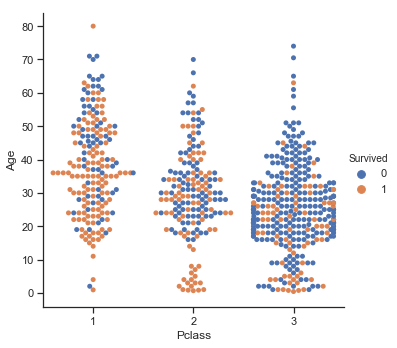

In [8]:
sns.catplot(x="Pclass", y="Age", data=training_data, hue="Survived", kind="swarm")

Across ages, we see that the Pclass affects survival above.

/Users/harold/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


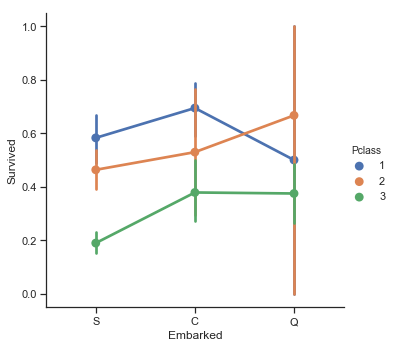

In [9]:
sns.catplot(x="Embarked", y="Survived", data=training_data, hue="Pclass", kind="point")

Another way to look at this is to use a **point** catplot.  This plot shows how both class and embarked affect survival.  Notice how we are able to get an automatic calculation of survival percentage.  Note also that there is the most variation with the Q Embarkment point

In [10]:
# I'm going to put my data adjustments here.  I'll need to use this on both the training and test data.
def adjust_data(td):
    # I'm using a convention that derived features start with lowercase letter.
    td['male'] = (td['Sex'] == 'male') * 1.0
    td['female'] = (td['Sex'] == 'female') * 1.0
    td['cherbourg'] = (td['Embarked'] == 'C') * 1.0
    td['queenstown'] = (td['Embarked'] == 'Q') * 1.0
    td['southampton'] = (td['Embarked'] == 'S') * 1.0
    td['companions'] = td['SibSp'] + td['Parch']
    td.Age.fillna(td.Age.mean(), inplace=True)
    td.Fare.fillna(td.Fare.mean(), inplace=True)

In [11]:
adjust_data(training_data)
training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,male,female,cherbourg,queenstown,southampton,companions
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1.0,0.0,0.0,0.0,1.0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0.0,1.0,1.0,0.0,0.0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.0,1.0,0.0,0.0,1.0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.0,1.0,0.0,0.0,1.0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1.0,0.0,0.0,0.0,1.0,0


In [12]:
training_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
male             0
female           0
cherbourg        0
queenstown       0
southampton      0
companions       0
dtype: int64

In [13]:
training_data.groupby('Parch').Survived.aggregate(['count', 'sum'])

,count,sum
Parch,,
0,678,233
1,118,65
2,80,40
3,5,3
4,4,0
5,5,1
6,1,0


In [14]:
training_data.groupby('SibSp').Survived.aggregate(['count', 'sum'])

,count,sum
SibSp,,
0,608,210
1,209,112
2,28,13
3,16,4
4,18,3
5,5,0
8,7,0


Number of parents/children (Parch) affected survival.
Number of siblings/spouses (SibSp) affected survival, espeically for those with none.
Can we add these?

In [15]:
training_data.groupby('companions').Survived.aggregate(['count', 'sum'])

,count,sum
companions,,
0,537,163
1,161,89
2,102,59
3,29,21
4,15,3
5,22,3
6,12,4
7,6,0
10,7,0


Survival rate best for 3 companions.  Also good for 2 companions, and slightly less good for 1 companion.
This can be seen in the plot below.

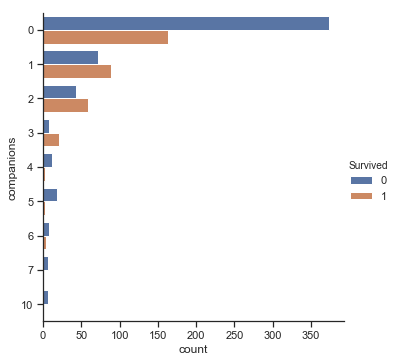

In [16]:
sns.catplot(y='companions', hue='Survived', kind='count', data=training_data)

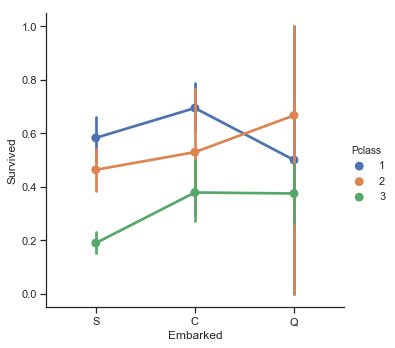

In [17]:
sns.catplot(x='Embarked', y='Survived', hue='Pclass', data=training_data, kind='point')

In [18]:
# declare features to be used in model
features = ['PassengerId', 'companions', 'Parch', 'Age', 'Fare', 'male', 
            'female', 'cherbourg', 'queenstown', 'southampton']
# Age Fare excluded for now due to NaN
X = training_data[features]
print('training size', training_data.shape)
print('filtered size', X.shape)
X.head()

training size (891, 18)
filtered size (891, 10)


,PassengerId,companions,Parch,Age,Fare,male,female,cherbourg,queenstown,southampton
0,1,1,0,22.0,7.2500,1.0,0.0,0.0,0.0,1.0
1,2,1,0,38.0,71.2833,0.0,1.0,1.0,0.0,0.0
2,3,0,0,26.0,7.9250,0.0,1.0,0.0,0.0,1.0
3,4,1,0,35.0,53.1000,0.0,1.0,0.0,0.0,1.0
4,5,0,0,35.0,8.0500,1.0,0.0,0.0,0.0,1.0


In [19]:
X.isnull().sum()

PassengerId    0
companions     0
Parch          0
Age            0
Fare           0
male           0
female         0
cherbourg      0
queenstown     0
southampton    0
dtype: int64

In [20]:
# transform data to gaussian normalized distribution
transformer = PowerTransformer()
X_norm = transformer.fit_transform(X)
X_norm[0:5]

array([[-2.14814111,  0.89382792, -0.56025296, -0.55626693, -0.87882001,
         0.73769513, -0.73769513, -0.48204268, -0.30756234,  0.61930636],
       [-2.13183003,  0.89382792, -0.56025296,  0.65726854,  1.33665056,
        -1.35557354,  1.35557354,  2.0745051 , -0.30756234, -1.61470971],
       [-2.117043  , -0.79616885, -0.56025296, -0.24157742, -0.79006485,
        -1.35557354,  1.35557354, -0.48204268, -0.30756234,  0.61930636],
       [-2.10329488,  0.89382792, -0.56025296,  0.43792346,  1.06735243,
        -1.35557354,  1.35557354, -0.48204268, -0.30756234,  0.61930636],
       [-2.09032172, -0.79616885, -0.56025296,  0.43792346, -0.77443897,
         0.73769513, -0.73769513, -0.48204268, -0.30756234,  0.61930636]])

In [21]:
# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X_norm, y, random_state=1)

In [22]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=4, min_samples_leaf=2, bootstrap=True, verbose=True)

In [23]:
model.fit(train_X, train_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=True,
            warm_start=False)

In [24]:
predictions = model.predict(val_X)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [25]:
error = mean_squared_error(predictions, val_y)
print('Error is ', error)

Error is  0.21524663677130046


In [26]:
# For first submission without age or fare, error is 0.22869955156950672
# Second submission using average values for missing data in Fare and Age, error is 0.2062780269058296.  However, this performed worse on the test data set.
# Third submission transforms data before processing.  error is 0.21524663677130046.  This solution improved ranking by 772 spots
# Fourth submission uses C=0.001 which means heavy regularization.  error is 0.21973094170403587
# Fifth submission replaces Parch and SibSp with the sum of the two: companions.  error is 0.21524663677130046
# Sixth submission changes C from 1.0 to 0.1.  Error is  0.2062780269058296
# Seventh submission using LinearSVC.  Error is 0.20179372197309417
# Eighth submission using RandomForestClassifier.  Error is 0.21524663677130046

In [27]:
correct = (val_y == predictions).count()
print('Correct predictions', correct, 'out of', predictions.size)

Correct predictions 223 out of 223


In [28]:
score = model.score(val_X, val_y)
print('Score is', score)

Score is 0.7847533632286996


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [29]:
# now do the test predictions
test_file = './input/test.csv'
test_data = pd.read_csv(test_file)
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [30]:
adjust_data(test_data)
test_X = test_data[features]
test_X_norm = transformer.fit_transform(test_X)
test_X_norm[0:5]

array([[-1.75656045, -0.79419976, -0.53844702,  0.3714598 , -0.90470822,
         0.75592895, -0.75592895, -0.56814154,  2.84375747, -1.35067551],
       [-1.74783791,  0.92212744, -0.53844702,  1.29336659, -1.0439114 ,
        -1.32287566,  1.32287566, -0.56814154, -0.35164743,  0.74037028],
       [-1.73911782, -0.79419976, -0.53844702,  2.33617511, -0.6458419 ,
         0.75592895, -0.75592895, -0.56814154,  2.84375747, -1.35067551],
       [-1.73040017, -0.79419976, -0.53844702, -0.21372555, -0.78074722,
         0.75592895, -0.75592895, -0.56814154, -0.35164743,  0.74037028],
       [-1.72168495,  1.35315565,  1.80663014, -0.62188168, -0.36721547,
        -1.32287566,  1.32287566, -0.56814154, -0.35164743,  0.74037028]])

In [31]:
test_y = model.predict(test_X_norm)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [32]:
output = pd.DataFrame({'PassengerId': test_X.PassengerId,
                       'Survived': test_y})
output.to_csv('submission.csv', index=False)

In [33]:
output[0:10]

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
